In [1]:
##The feature engineering was redone starting from the original work and with extra work by us.

In [2]:

#updates:
#applied imputation into numerical and categorical data to improve the score by 0.327, now 0.9194



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy import stats
from plotly.offline import iplot, init_notebook_mode

init_notebook_mode(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold

import gc
import os 

#print where those datasets are located 
from sklearn.preprocessing import minmax_scale
# from sklearn.cluster import KMeans

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


#df_trans = pd.read_csv('train_transaction.csv')
df_trans = pd.read_csv('train_transaction.csv',index_col='TransactionID')
df_test_trans = pd.read_csv('test_transaction.csv',index_col='TransactionID')

#record index of test datasets
test_trans_id = df_test_trans.index

#df_id = pd.read_csv('train_identity.csv')
df_id = pd.read_csv('train_identity.csv',index_col='TransactionID')
df_test_id = pd.read_csv('test_identity.csv',index_col='TransactionID')


sample_submission = pd.read_csv('sample_submission.csv', index_col='TransactionID')


In [3]:
def id_split(dataframe):
    
    #expand = split and expand to seperate column
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0]
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1]

    dataframe['id_34'] = dataframe['id_34'].str.split(':', expand=True)[1]
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]
    
    #very specifically group device brands to help making decision
    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    #make the device name that are less than 200 to be other
    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    
    #new column to record that this device has id???
    dataframe['had_id'] = 1
    gc.collect()
    
    return dataframe

In [4]:
df_id = id_split(df_id)
df_test_id = id_split(df_test_id)

In [5]:
df_id

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,DeviceInfo,device_name,device_version,OS_id_30,version_id_30,browser_id_31,version_id_31,screen_width,screen_height,had_id
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,SAMSUNG SM-G892A Build/NRD90M,Samsung,NRD90M,Android,7.0,samsung,browser,2220,1080,1
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,iOS Device,iOS Device,None,iOS,11.1.2,mobile,safari,1334,750,1
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,Windows,Windows,None,NaN,NaN,chrome,62.0,NaN,NaN,1
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,chrome,62.0,NaN,NaN,1
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,MacOS,MacOS,None,Mac,OS,chrome,62.0,1280,800,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577521,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,F3111 Build/33.3.A.1.97,Others,33.3.A.1.97,NaN,NaN,chrome,66.0,NaN,NaN,1
3577526,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN,NaN,NaN,...,A574BL Build/NMF26F,Others,NMF26F,Android,7.1.1,chrome,55.0,855,480,1
3577529,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN,NaN,NaN,...,Moto E (4) Plus Build/NMA26.42-152,Motorola,NMA26.42-152,NaN,NaN,chrome,65.0,NaN,NaN,1


In [6]:

##do not need to include right_index
df_train = df_trans.merge(df_id, how='left', left_index=True,  on='TransactionID')
df_test = df_test_trans.merge(df_test_id, how='left', left_index=True, on='TransactionID')


In [7]:
df_train.iloc[:,400:]

,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,...,DeviceInfo,device_name,device_version,OS_id_30,version_id_30,browser_id_31,version_id_31,screen_width,screen_height,had_id
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,...,SAMSUNG SM-G892A Build/NRD90M,Samsung,NRD90M,Android,7.0,samsung,browser,2220,1080,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3577535,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3577537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#fill na for D
df_train['D2'].fillna(0)
df_test['D2'].fillna(0)
#D missing

df_train['D_null'] = df_train.loc[:,'D1':'D15'].isna().sum(axis=1).astype(np.int8)
df_test['D_null'] = df_test.loc[:,'D1':'D15'].isna().sum(axis=1).astype(np.int8)
    
##isnull feature: some features have missing values all together so one will be put here.
#M1, M4, id_14,id_01, id_07, 

df_train['devicename_null'] = df_train.loc[:,'device_name'].isna().astype(np.int8)
df_test['devicename_null'] = df_test.loc[:,'device_name'].isna().astype(np.int8)

##ids 
df_train['id_null'] = df_id.loc[:,"id_01":"id_38"].isna().sum(axis=1).astype(np.int8)
df_test['id_null'] = df_test_id.loc[:,"id_01":"id_38"].isna().sum(axis=1).astype(np.int8)


##C1-C14 can use np.floor_divide(col, 100) to bin the numerical data. or use pandas qcut() see FE p.15 for quartile binning.


In [9]:
df_train['id_null']



TransactionID
2987000     NaN
2987001     NaN
2987002     NaN
2987003     NaN
2987004    17.0
           ... 
3577535     NaN
3577536     NaN
3577537     NaN
3577538     NaN
3577539     NaN
Name: id_null, Length: 590540, dtype: float64

In [10]:

#add total na for train and test data. 
df_train['tot_na'] = df_train.isna().sum(axis=1).astype(np.int8) 
df_test['tot_na'] = df_test.isna().sum(axis=1).astype(np.int8)

print(df_train.head())
print(df_test.head())


# y_train = df_train['isFraud'].copy()
del df_trans, df_id, df_test_trans, df_test_id
gc.collect()






               isFraud  TransactionDT  TransactionAmt ProductCD  card1  card2  \
TransactionID                                                                   
2987000              0          86400            68.5         W  13926    NaN   
2987001              0          86401            29.0         W   2755  404.0   
2987002              0          86469            59.0         W   4663  490.0   
2987003              0          86499            50.0         W  18132  567.0   
2987004              0          86506            50.0         H   4497  514.0   

               card3       card4  card5   card6  ...  version_id_30  \
TransactionID                                    ...                  
2987000        150.0    discover  142.0  credit  ...            NaN   
2987001        150.0  mastercard  102.0  credit  ...            NaN   
2987002        150.0        visa  166.0   debit  ...            NaN   
2987003        150.0  mastercard  117.0   debit  ...            NaN   
298700

40

In [11]:
df_train.loc[3577531,"screen_height"]

'1600'

In [12]:
#https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm#
#removed V300 feature
useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294',
                    'DeviceType', 'DeviceInfo', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
                   'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id','tot_na','id_null','D_null','devicename_null']
print(len(useful_features))

249


In [13]:
cols_to_drop = [col for col in df_train.columns if col not in useful_features]
cols_to_drop.remove('isFraud')
cols_to_drop.remove('TransactionDT')

In [14]:
df_train = df_train.drop(cols_to_drop, axis=1)
df_test = df_test.drop(cols_to_drop, axis=1)

In [16]:
# New feature - log of transaction amount.

# New feature - decimal part of the transaction amount.
df_train['TransactionAmt_decimal'] = ((df_train['TransactionAmt'] - df_train['TransactionAmt'].astype(int)) * 1000).astype(int)
df_test['TransactionAmt_decimal'] = ((df_test['TransactionAmt'] - df_test['TransactionAmt'].astype(int)) * 1000).astype(int)

# New feature - day of week in which a transaction happened.
df_train['Transaction_day_of_week'] = np.floor((df_train['TransactionDT'] / (3600 * 24) - 1) % 7)
df_test['Transaction_day_of_week'] = np.floor((df_test['TransactionDT'] / (3600 * 24) - 1) % 7)

# is weekend
df_train['is_weekend'] = [1 if day >5 else 0 for day in df_train['Transaction_day_of_week']]
df_test['is_weekend'] =  [1 if day >5 else 0 for day in df_test['Transaction_day_of_week']]

# New feature - hour of the day in which a transaction happened.
df_train['Transaction_hour'] = np.floor(df_train['TransactionDT'] / 3600) % 24
df_test['Transaction_hour'] = np.floor(df_test['TransactionDT'] / 3600) % 24

# Some arbitrary features interaction
for feature in [ 'DeviceInfo__P_emaildomain', 'card1__card2',
                'card2__dist1', 'card1__card5', 'card2__P_emaildomain', 'addr1__card1','TransactionAmt__card1']:

    f1, f2 = feature.split('__')
    df_train[feature] = df_train[f1].astype(str) + '_' + df_train[f2].astype(str)
    df_test[feature] = df_test[f1].astype(str) + '_' + df_test[f2].astype(str)

    le = preprocessing.LabelEncoder()
    le.fit(list(df_train[feature].astype(str).values) + list(df_test[feature].astype(str).values))
    df_train[feature] = le.transform(list(df_train[feature].astype(str).values))
    df_test[feature] = le.transform(list(df_test[feature].astype(str).values))

# Encoding - count encoding for both df_train and df_test
for feature in ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']:
    df_train[feature + '_count_full'] = df_train[feature].map(pd.concat([df_train[feature], df_test[feature]], ignore_index=True).value_counts(dropna=False))
    df_test[feature + '_count_full'] = df_test[feature].map(pd.concat([df_train[feature], df_test[feature]], ignore_index=True).value_counts(dropna=False))

# targe mean encoding - play around card1 to make something happen because it can easily overfit but remove it will largely reduce
# the valid auc. 





In [17]:
df_train = df_train.reset_index()
df_train

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,card1__card5,card2__P_emaildomain,addr1__card1,TransactionAmt__card1,card1_count_full,card2_count_full,card3_count_full,card4_count_full,card5_count_full,card6_count_full
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,4648,7891,29248,256183,56,17587,956845,9524,309,267648
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,10936,4652,32205,131914,1338,5593,956845,347386,49491,267648
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,12999,6005,35560,241442,1794,70496,956845,719649,102930,824959
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,9636,7407,47566,212210,7635,11287,956845,347386,47061,824959
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,12822,6414,40560,212921,30,27225,956845,347386,49491,267648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,...,15048,7891,23935,206752,2110,17587,956845,719649,553537,824959
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,...,522,1927,11696,175152,25,13274,956845,347386,153109,824959
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,...,2410,7787,17483,139224,1373,1432,956845,347386,153109,824959
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,...,16445,5836,39726,29709,5021,10151,956845,347386,153109,824959


In [18]:

#k fold cross validation target mean coding to avoid overfitting

N_SPLITS = 5
SEED = 100

folds = KFold(n_splits=N_SPLITS,shuffle = False, random_state=SEED)
# Test Data and expport DF
  
score = 0
y_result = 0

mean_of_target = df_train['isFraud'].mean()

target_mean_list =['card1','card1__card2','card2', 'addr1__card1','TransactionAmt__card1','TransactionAmt']

# kfold target mean encoding for regularisation

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    print('Fold:',fold_+1)
    tr_x = df_train.iloc[trn_idx,:] 
    vl_x = df_train.iloc[val_idx,:]  
    
    for col in target_mean_list:
        df_train.loc[val_idx,f'{col}_target_enc'] = vl_x[col].map(tr_x.groupby(col)['isFraud'].mean())

        df_train[f'{col}_target_enc'].fillna(mean_of_target, inplace = True)
                                                        
for col in target_mean_list:
                                                            
    df_test[f'{col}_target_enc'] = df_test[col].map(df_train.groupby(col)[f'{col}_target_enc'].mean())

    df_test[f'{col}_target_enc'].fillna(mean_of_target, inplace = True)

Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5


In [ ]:
df_train
df_test
mean_of_target

In [19]:

columns_a = ['TransactionAmt','D15']  #numerical feature
columns_b = [ 'addr1','card1','card2']  #categorical feature

for col_a in columns_a:
    for col_b in columns_b:
        for df in [df_train, df_test]:
            df[f'{col_a}_to_median_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform('median')
            df[f'{col_a}_to_std_{col_b}'] = df[col_a] / df.groupby([col_b])[col_a].transform('std')

            


In [20]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)
    
    df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1])
    df_test[c + '_suffix'] = df_test[c].map(lambda x: str(x).split('.')[-1])
    
    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')



In [21]:
#label encoding the rest 
for col in df_train.columns:
    if df_train[col].dtype == 'object':
        le = preprocessing.LabelEncoder()
        le.fit(list(df_train[col].astype(str).values) + list(df_test[col].astype(str).values))
        df_train[col] = le.transform(list(df_train[col].astype(str).values))
        df_test[col] = le.transform(list(df_test[col].astype(str).values))

In [22]:
#why sort ??
X_train = df_train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT','TransactionID'], axis=1)
y_train = df_train.sort_values('TransactionDT')['isFraud']

X_test = df_test.drop(['TransactionDT'], axis=1)

del df_train, df_test
gc.collect()

20

In [ ]:
##do final step 

#X_train = reduce_mem_usage(X_train)
#X_test = reduce_mem_usage(X_test)
##Deal with missing data

In [23]:
from sklearn.model_selection import KFold
import lightgbm as lgb
##The following will carry out automated parameters optimisation for mainly accuray and overfitting related parameters based on Bayesian optimisation
from sklearn.model_selection import KFold, train_test_split
from sklearn import metrics





In [33]:
##Those parameters are the optimised ones for 4 hours 
#small min_data, large min_leaves, small learning rate, gbdt. 
#https://www.kaggle.com/kyakovlev/ieee-gb-2-make-amount-useful-again
SEED = 123
best_param = {
                    'objective':'binary',
                    'boosting_type':'gbdt',
                    'metric':'auc',
                    'n_jobs':-1,
                    'learning_rate':0.01,
                    'num_leaves': 2**9,
                    'max_depth':-1,
                    'tree_learner':'serial',
                    'colsample_bytree': 0.5,
                    'subsample_freq':1,
                    'subsample':0.7,
                    'max_bin':500,
                    'verbose':-1,
                    'seed': SEED,
                    'early_stopping_rounds':100, 
                } 

In [26]:
cate_list = ['ProductCD','card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain','DeviceType', 'DeviceInfo', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
                   'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id','devicename_null','P_emaildomain_bin','P_emaildomain_suffix',
            'DeviceInfo__P_emaildomain','card2__dist1', 'card1__card5', 'card2__P_emaildomain', 'addr1__card1','TransactionAmt__card1','card1__card2','Transaction_hour']

In [34]:
N_SPLITS = 5
SEED = 6

columns = X_train.columns
feature_importances = pd.DataFrame()
feature_importances['feature'] = columns

folds = KFold(n_splits=N_SPLITS, random_state=SEED)
# Test Data and expport DF
  
y_preds = np.zeros(X_test.shape[0])
y_oof = np.zeros(X_train.shape[0])

score = 0
y_result = 0
print("running")
# use stratified fold to ensure the split datasets have same portion of postive and negative data.
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print('Fold:',fold_+1)
    tr_x, tr_y = X_train.iloc[trn_idx,:], y_train.iloc[trn_idx]    
    vl_x, v_y = X_train.iloc[val_idx,:], y_train.iloc[val_idx]    
    train_data = lgb.Dataset(tr_x, label=tr_y)
    valid_data = lgb.Dataset(vl_x, label=v_y )  
        
    #this will run very slow. 
    num_round =5000
        
    #here valid sets are the criteria for stopping, when the auc score for valid sets do not improve after num_round, then it will stop. 
    estimator = lgb.train(
            best_param,
            train_data, 
            num_round,
            valid_sets = [train_data,valid_data],
            #print evaluation at each step
            verbose_eval = 10,
            )

    y_pred_valid = estimator.predict(vl_x)
    y_oof[val_idx] = y_pred_valid
    print(f"Fold {fold_ + 1} | AUC: {roc_auc_score(v_y, y_pred_valid)}")
    
    #score is the roc_auc of valid pred 
    score += roc_auc_score(v_y, y_pred_valid) / N_SPLITS
    y_result += estimator.predict(X_test) / N_SPLITS
    # we are not sure what fold is best for us
    # so we will average prediction results 
    # over folds; meaning each fold we predict test data and then get average.
    
    feature_importances[f'fold_{fold_ + 1}'] = estimator.feature_importance()

    del train_data, valid_data
    gc.collect()
print(f"\nMean AUC = {score}")
print(f"Out of folds AUC = {roc_auc_score(y_train, y_oof)}")
    #print('LOG loss', metrics.log_loss(RESULTS['isFraud'], RESULTS['stratifiedkfold']))


running
Fold: 1
Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.936756	valid_1's auc: 0.875975
[20]	training's auc: 0.943148	valid_1's auc: 0.876917
[30]	training's auc: 0.947935	valid_1's auc: 0.878738
[40]	training's auc: 0.952199	valid_1's auc: 0.881516
[50]	training's auc: 0.955236	valid_1's auc: 0.882592
[60]	training's auc: 0.958627	valid_1's auc: 0.884482
[70]	training's auc: 0.961442	valid_1's auc: 0.88592
[80]	training's auc: 0.96398	valid_1's auc: 0.888004
[90]	training's auc: 0.966114	valid_1's auc: 0.889213
[100]	training's auc: 0.967971	valid_1's auc: 0.890508
[110]	training's auc: 0.969838	valid_1's auc: 0.891589
[120]	training's auc: 0.971668	valid_1's auc: 0.892091
[130]	training's auc: 0.973492	valid_1's auc: 0.892643
[140]	training's auc: 0.975213	valid_1's auc: 0.893402
[150]	training's auc: 0.976953	valid_1's auc: 0.89433
[160]	training's auc: 0.97887	valid_1's auc: 0.894668
[170]	training's auc: 0.980454	valid_1's auc: 0.895007

[1530]	training's auc: 1	valid_1's auc: 0.914731
[1540]	training's auc: 1	valid_1's auc: 0.914821
[1550]	training's auc: 1	valid_1's auc: 0.914721
[1560]	training's auc: 1	valid_1's auc: 0.914781
[1570]	training's auc: 1	valid_1's auc: 0.914842
[1580]	training's auc: 1	valid_1's auc: 0.914938
[1590]	training's auc: 1	valid_1's auc: 0.914985
[1600]	training's auc: 1	valid_1's auc: 0.915028
[1610]	training's auc: 1	valid_1's auc: 0.915102
[1620]	training's auc: 1	valid_1's auc: 0.915117
[1630]	training's auc: 1	valid_1's auc: 0.915182
[1640]	training's auc: 1	valid_1's auc: 0.915207
[1650]	training's auc: 1	valid_1's auc: 0.91521
[1660]	training's auc: 1	valid_1's auc: 0.915215
[1670]	training's auc: 1	valid_1's auc: 0.915251
[1680]	training's auc: 1	valid_1's auc: 0.915261
[1690]	training's auc: 1	valid_1's auc: 0.915196
[1700]	training's auc: 1	valid_1's auc: 0.915146
[1710]	training's auc: 1	valid_1's auc: 0.915178
[1720]	training's auc: 1	valid_1's auc: 0.915259
[1730]	training's auc

c:\users\oem\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.935153	valid_1's auc: 0.908178
[20]	training's auc: 0.942111	valid_1's auc: 0.912477
[30]	training's auc: 0.947203	valid_1's auc: 0.914827
[40]	training's auc: 0.950855	valid_1's auc: 0.916449
[50]	training's auc: 0.953888	valid_1's auc: 0.917445
[60]	training's auc: 0.956868	valid_1's auc: 0.918957
[70]	training's auc: 0.959865	valid_1's auc: 0.919659
[80]	training's auc: 0.962081	valid_1's auc: 0.920314
[90]	training's auc: 0.964696	valid_1's auc: 0.921016
[100]	training's auc: 0.96693	valid_1's auc: 0.921699
[110]	training's auc: 0.969214	valid_1's auc: 0.922311
[120]	training's auc: 0.97127	valid_1's auc: 0.923081
[130]	training's auc: 0.973022	valid_1's auc: 0.923636
[140]	training's auc: 0.974966	valid_1's auc: 0.924066
[150]	training's auc: 0.976535	valid_1's auc: 0.924766
[160]	training's auc: 0.978253	valid_1's auc: 0.925495
[170]	training's auc: 0.980061	valid_1's auc: 0.925901
[180]	trainin

[1540]	training's auc: 1	valid_1's auc: 0.940416
[1550]	training's auc: 1	valid_1's auc: 0.940377
[1560]	training's auc: 1	valid_1's auc: 0.940406
[1570]	training's auc: 1	valid_1's auc: 0.940462
[1580]	training's auc: 1	valid_1's auc: 0.940419
[1590]	training's auc: 1	valid_1's auc: 0.940398
[1600]	training's auc: 1	valid_1's auc: 0.940397
[1610]	training's auc: 1	valid_1's auc: 0.940481
[1620]	training's auc: 1	valid_1's auc: 0.940471
[1630]	training's auc: 1	valid_1's auc: 0.940499
[1640]	training's auc: 1	valid_1's auc: 0.940524
[1650]	training's auc: 1	valid_1's auc: 0.940502
[1660]	training's auc: 1	valid_1's auc: 0.940534
[1670]	training's auc: 1	valid_1's auc: 0.940576
[1680]	training's auc: 1	valid_1's auc: 0.940625
[1690]	training's auc: 1	valid_1's auc: 0.940692
[1700]	training's auc: 1	valid_1's auc: 0.9407
[1710]	training's auc: 1	valid_1's auc: 0.940737
[1720]	training's auc: 1	valid_1's auc: 0.940811
[1730]	training's auc: 1	valid_1's auc: 0.940806
[1740]	training's auc:

c:\users\oem\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.933661	valid_1's auc: 0.908395
[20]	training's auc: 0.940541	valid_1's auc: 0.911977
[30]	training's auc: 0.946002	valid_1's auc: 0.914542
[40]	training's auc: 0.95079	valid_1's auc: 0.917326
[50]	training's auc: 0.954603	valid_1's auc: 0.918705
[60]	training's auc: 0.957424	valid_1's auc: 0.920131
[70]	training's auc: 0.960107	valid_1's auc: 0.920977
[80]	training's auc: 0.962801	valid_1's auc: 0.922
[90]	training's auc: 0.965667	valid_1's auc: 0.922993
[100]	training's auc: 0.968174	valid_1's auc: 0.924134
[110]	training's auc: 0.970487	valid_1's auc: 0.925376
[120]	training's auc: 0.972563	valid_1's auc: 0.926274
[130]	training's auc: 0.974692	valid_1's auc: 0.927449
[140]	training's auc: 0.976731	valid_1's auc: 0.927795
[150]	training's auc: 0.978503	valid_1's auc: 0.928232
[160]	training's auc: 0.9804	valid_1's auc: 0.928591
[170]	training's auc: 0.981834	valid_1's auc: 0.928954
[180]	training's 

c:\users\oem\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.930733	valid_1's auc: 0.924737
[20]	training's auc: 0.938416	valid_1's auc: 0.928988
[30]	training's auc: 0.94388	valid_1's auc: 0.931388
[40]	training's auc: 0.948167	valid_1's auc: 0.933293
[50]	training's auc: 0.952205	valid_1's auc: 0.934101
[60]	training's auc: 0.955628	valid_1's auc: 0.935175
[70]	training's auc: 0.958897	valid_1's auc: 0.936329
[80]	training's auc: 0.961322	valid_1's auc: 0.937148
[90]	training's auc: 0.963795	valid_1's auc: 0.938083
[100]	training's auc: 0.966349	valid_1's auc: 0.939437
[110]	training's auc: 0.968805	valid_1's auc: 0.940236
[120]	training's auc: 0.970933	valid_1's auc: 0.941203
[130]	training's auc: 0.972933	valid_1's auc: 0.941787
[140]	training's auc: 0.975034	valid_1's auc: 0.942165
[150]	training's auc: 0.977032	valid_1's auc: 0.943085
[160]	training's auc: 0.978977	valid_1's auc: 0.943737
[170]	training's auc: 0.980591	valid_1's auc: 0.944239
[180]	traini

c:\users\oem\appdata\local\programs\python\python37\lib\site-packages\lightgbm\engine.py:123: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds.
[10]	training's auc: 0.93564	valid_1's auc: 0.900898
[20]	training's auc: 0.941856	valid_1's auc: 0.903602
[30]	training's auc: 0.947636	valid_1's auc: 0.905238
[40]	training's auc: 0.952379	valid_1's auc: 0.907676
[50]	training's auc: 0.955571	valid_1's auc: 0.908731
[60]	training's auc: 0.958155	valid_1's auc: 0.909225
[70]	training's auc: 0.960662	valid_1's auc: 0.910491
[80]	training's auc: 0.963145	valid_1's auc: 0.911985
[90]	training's auc: 0.9653	valid_1's auc: 0.912798
[100]	training's auc: 0.967465	valid_1's auc: 0.913771
[110]	training's auc: 0.96969	valid_1's auc: 0.914446
[120]	training's auc: 0.971683	valid_1's auc: 0.915157
[130]	training's auc: 0.973711	valid_1's auc: 0.91573
[140]	training's auc: 0.975667	valid_1's auc: 0.916055
[150]	training's auc: 0.977483	valid_1's auc: 0.916488
[160]	training's auc: 0.979394	valid_1's auc: 0.917068
[170]	training's auc: 0.980919	valid_1's auc: 0.917825
[180]	training's

##trick here 
##for oof = 0.93547, LB score is 0.9458
##for oof = 0.936, LB score is 0.945
##for oof = 0.9376, LB score is 0.9458

#previous
#0.9313 LB: 0.9418 


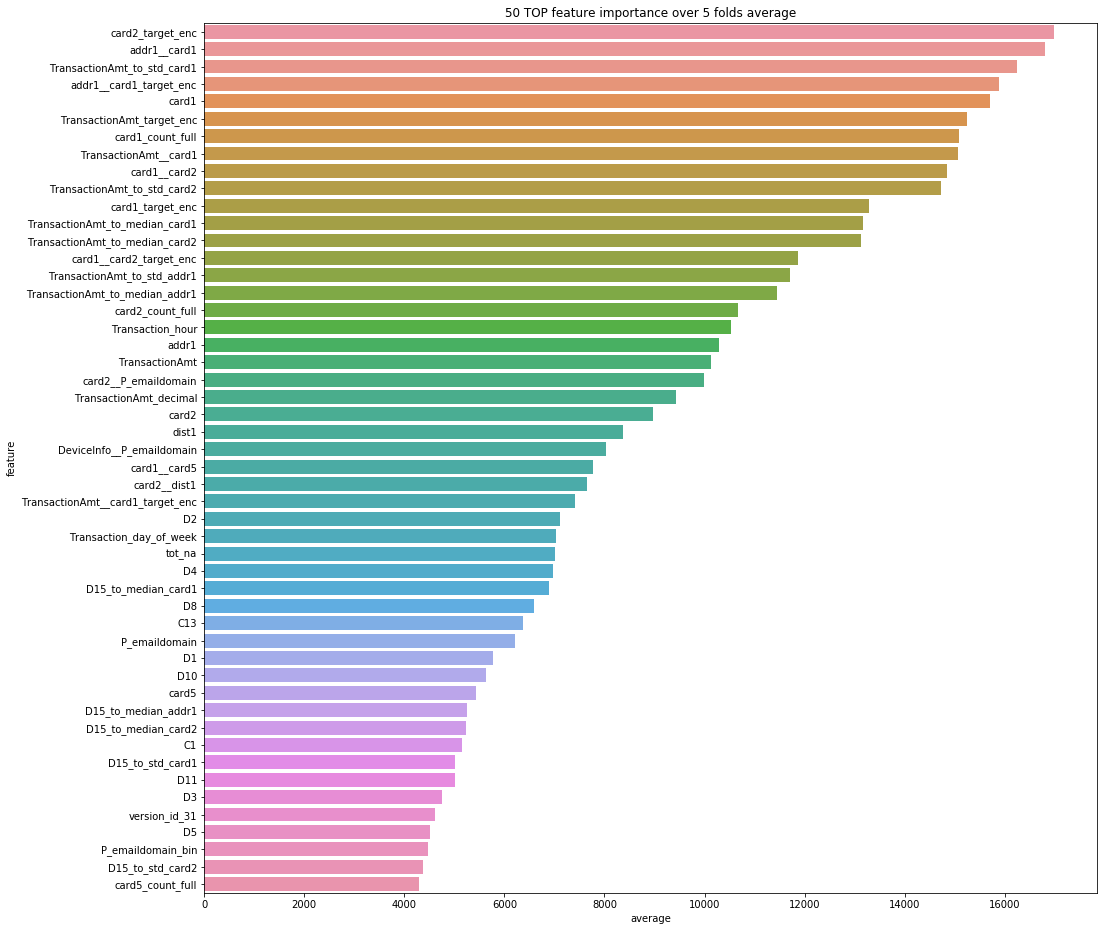

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
##take the mean of each feature importance of all folds. 
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [38]:

sub = pd.DataFrame(columns=['TransactionID','isFraud'])
sub['TransactionID'] = test_trans_id
sub['isFraud'] = y_result
sub




sub.to_csv("submission54th-updated-03.csv",index=False)

sum(y_result>0.1)
#keep in mind
#15000 - 18000 are the reasonable.

14956

In [39]:
sum(y_result>0.5)

7863